In [ ]:
import pandas as pd
import numpy as np
import os
import warnings
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

CURR_DIR = "/content/drive/My Drive"
DATA_FILE = "trainingSet.csv"

train_df = pd.read_csv(os.path.join(CURR_DIR, DATA_FILE))

DATA_FILE = "testSet.csv"
test_df = pd.read_csv(os.path.join(CURR_DIR, DATA_FILE))

DATA_FILE = "profiles_full.csv"
full_df = pd.read_csv(os.path.join(CURR_DIR, DATA_FILE))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# get features
def get_X(data):
    return data[:,:-1]

# get label
def get_Y(data):
    return data[:,-1]
  
# train model
def logReg(train_df, test_df):
    X_train = get_X(train_df.iloc[:,:].values)
    X_test = get_X(test_df.iloc[:,:].values)
    Y_train = get_Y(train_df.iloc[:,:].values)
    Y_test = get_Y(test_df.iloc[:,:].values)

    # Standardize Feature
    ss = StandardScaler()
    X_train = ss.fit_transform(X_train) 

    # L2 Regularization; Gradient Descent; 
    lr = LogisticRegression(C=1, penalty='l2', tol=1e-6, max_iter=500, solver='sag', class_weight='balanced') #, max_iter=100
    model = lr.fit(X_train, Y_train)
    acc_train = model.score(X_train,Y_train)

    X_test = ss.fit_transform(X_test)
    acc_test = model.score(X_test, Y_test)

    return acc_train, acc_test

## Train Model

In [ ]:
warnings.filterwarnings(action = 'ignore', category=ConvergenceWarning)

In [ ]:
acc_train, acc_test = logReg(train_df, test_df)
print("accuracy on training set: ", acc_train)
print("accuracy on test set: ", acc_test)

accuracy on training set:  0.86175
accuracy on test set:  0.7825


## K-Fold Cross Validation, k=10

In [ ]:
# partition the training data into 10 disjoint set. 
def K_Flod_spilt(K, fold, data,header):
    kf = KFold(n_splits=K)
    i = 0  # i-th fold as test_set, range[0,K-1]

    for train_index, test_index in kf.split(data):
        if i == fold:
            trainSet, testSet = data[train_index], data[test_index]
            return pd.DataFrame(trainSet, columns=header), pd.DataFrame(testSet, columns=header)
        i += 1

def frac_TrainSet(t_frac, df):
    df = df.sample(frac=t_frac, random_state=32)
    #     df = df.reset_index(drop=True) # reset index
    return df

def learn_model(t_frac, K, df):
    trainingSet_accuracy = np.zeros([len(t_frac), K])
    testSet_accuracy = np.zeros([len(t_frac), K])

    avg_train_acc = np.zeros(len(t_frac))
    avg_test_acc = np.zeros(len(t_frac))

    sterr_train_acc = np.zeros(len(t_frac))
    sterr_test_acc = np.zeros(len(t_frac))

    size_of_train_data = np.zeros(len(t_frac))

    header = df.columns
    dataset = df.values

    for index, f in enumerate(t_frac):
        for idx in range(K):

            # K-fold splits
            trainSet, testSet = K_Flod_spilt(K, idx, dataset,header)  # take idx-th fold as testSet
            # frac_trainSet
            trainSet = frac_TrainSet(f, trainSet)  # take f % from trainSet to learn model
            
            train_acc, test_acc = logReg(trainSet, testSet)

            trainingSet_accuracy[index, idx] = train_acc
            testSet_accuracy[index, idx] = test_acc

        # average accuracy over the ten trials
        avg_train_acc[index] = np.mean(trainingSet_accuracy[index])
        avg_test_acc[index] = np.mean(testSet_accuracy[index])
        # standard error
        sterr_train_acc[index] = np.std(trainingSet_accuracy[index], ddof=1) / np.sqrt(K)
        sterr_test_acc[index] = np.std(testSet_accuracy[index], ddof=1) / np.sqrt(K)

        size_of_train_data[index] = len(trainSet)

        print("========== frac: ", f,"==========")
        print("accuracy on training set: % .3f" % avg_train_acc[index])
        print("accuracy on test set: %.3f" % avg_test_acc[index])

    
    return avg_train_acc, avg_test_acc, sterr_train_acc, sterr_test_acc, size_of_train_data

In [ ]:
t_frac = [0.075, 0.2, 0.5, 0.75, 1]
K = 10

# Using full_df only
lr_avg_train_acc, lr_avg_test_acc, lr_sterr_train_acc, lr_sterr_test_acc, lr_size_of_train_data = learn_model(t_frac,K, full_df)

========== frac:  0.075 ==========
accuracy on training set:  0.991
accuracy on test set: 0.715
========== frac:  0.2 ==========
accuracy on training set:  0.927
accuracy on test set: 0.754
========== frac:  0.5 ==========
accuracy on training set:  0.876
accuracy on test set: 0.776
========== frac:  0.75 ==========
accuracy on training set:  0.867
accuracy on test set: 0.783
========== frac:  1 ==========
accuracy on training set:  0.862
accuracy on test set: 0.786


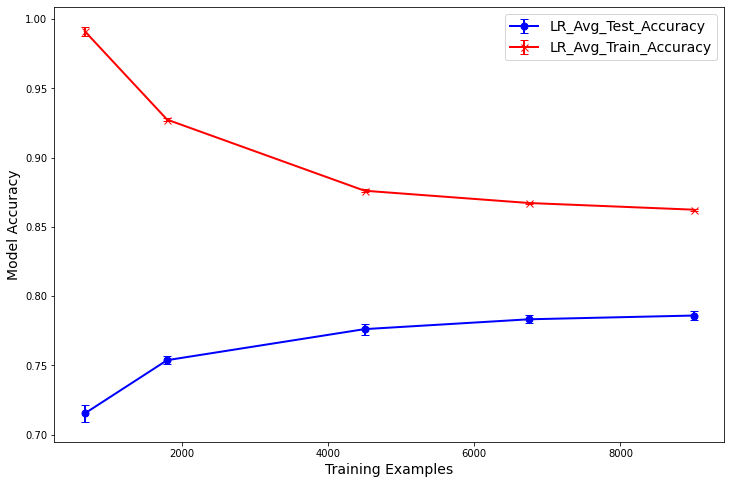

In [ ]:
# lr

plt.figure(figsize=(12,8))
plt.errorbar(lr_size_of_train_data, lr_avg_test_acc, yerr=lr_sterr_test_acc, fmt='b-o', ecolor='b',
              label='LR_Avg_Test_Accuracy', lw=2, elinewidth=2, ms=7, capsize=4)
plt.errorbar(lr_size_of_train_data, lr_avg_train_acc, yerr=lr_sterr_train_acc, fmt='r-x', ecolor='r',
              label='LR_Avg_Train_Accuracy', lw=2, elinewidth=2, ms=7, capsize=4)
plt.legend(fontsize=14, loc='upper right')  
plt.xlabel('Training Examples', fontsize=14)
plt.ylabel('Model Accuracy', fontsize=14)

plt.show()